In [259]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

In [260]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [261]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'YEAR', 'QUARTER', 'NAMEADDR']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    permits = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_STATUS_DATE'])
    permits = permits.drop_duplicates()
    permits = permits.set_index('PERMIT_ID')
    
    X = pd.read_csv("data_complete/Building_Permits_ISSUED.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_ISSUED_DATE'])
    X = X.drop_duplicates()
    X = X.set_index('PERMIT_ID')
    X.rename(columns = {'PERMIT_ISSUED_DATE':'PERMIT_DATE'}, inplace = True)
    return X, permits

permits, more_permits = loadPermits()
    
df = loadData()
df = df[columns]
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df.head()
permits.count()

PERMIT_DATE    344941
dtype: int64

In [262]:
permits = permits.join(more_permits, how='inner')

# keep only first and last entry for each building
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="first")
construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="last")

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))

data = data[~data.duplicated('PERMIT_ID')]
data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

# Duration = last 'construction' entry year/quarter - permit issue year/quarter in quarters
data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'NAMEADDR',# , 'PERMIT_DATE', 'YEAR_START', 'QUARTER_START'
             'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'COST', 'PERMIT_TYPE']]#, 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data['COST'] = data['COST'].fillna(data['COST'].mean()).astype('int64')
data.groupby(['PERMIT_TYPE']).count()

565
679


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,COST
PERMIT_TYPE,,,,,,,,,
additions alterations or repairs,294,294,294,294,294,294,294,294,294
new construction,101,101,101,101,101,101,101,101,101
new construction wood frame,280,280,280,280,280,280,280,280,280
otc alterations permit,4,4,4,4,4,4,4,4,4


In [263]:
# Split completed by 2017Q1 and still in construction by 2017Q1
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]

print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())

Completed by 2017:  464
Still in construction by 2017:  215


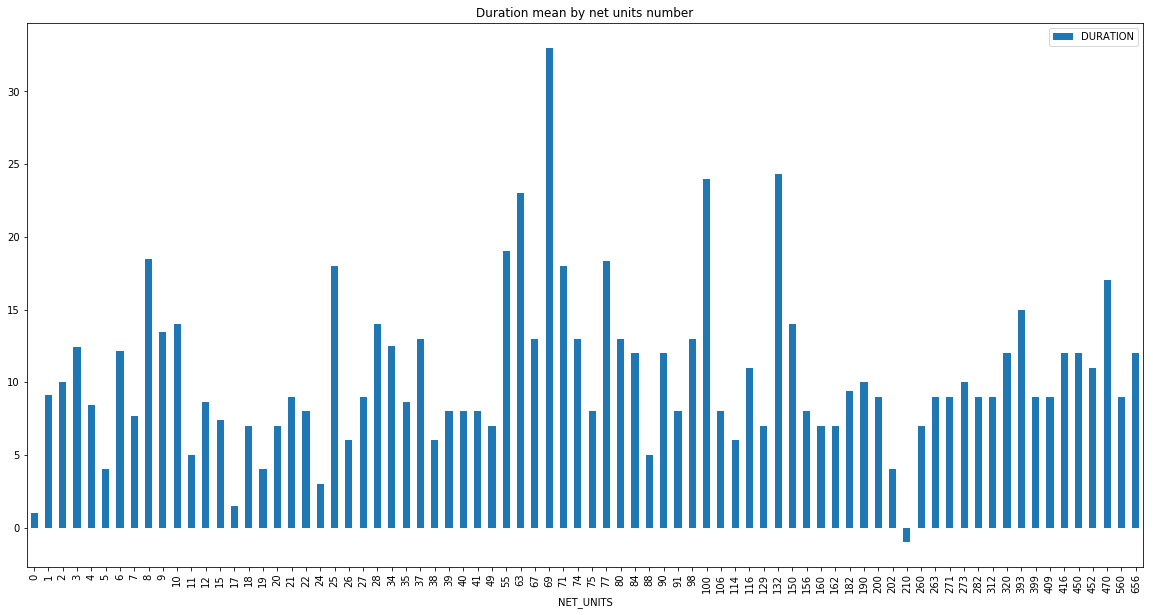

In [264]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10), title = "Duration mean by net units number")

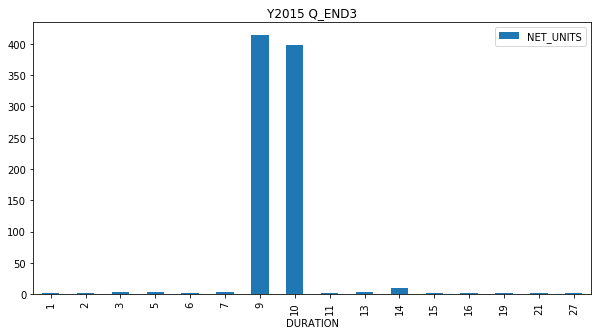

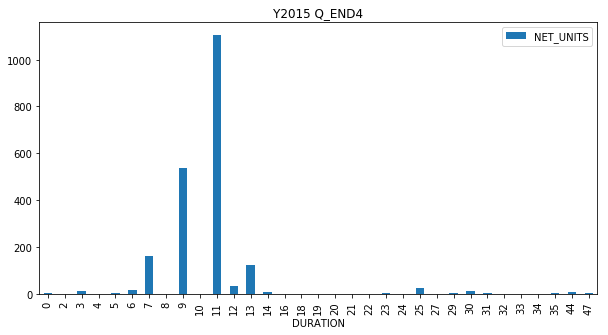

In [265]:
def plot_duration(year, quarter_end):
    d1 = complete[(complete['YEAR_END'] == year) & (complete['QUARTER_END'] == quarter_end)]
    grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(10,5), title = "Y" + str(year) + " Q_END" + str(quarter_end))

#plot_duration(2015, 1)
#plot_duration(2015, 2)
plot_duration(2015, 3)
plot_duration(2015, 4)

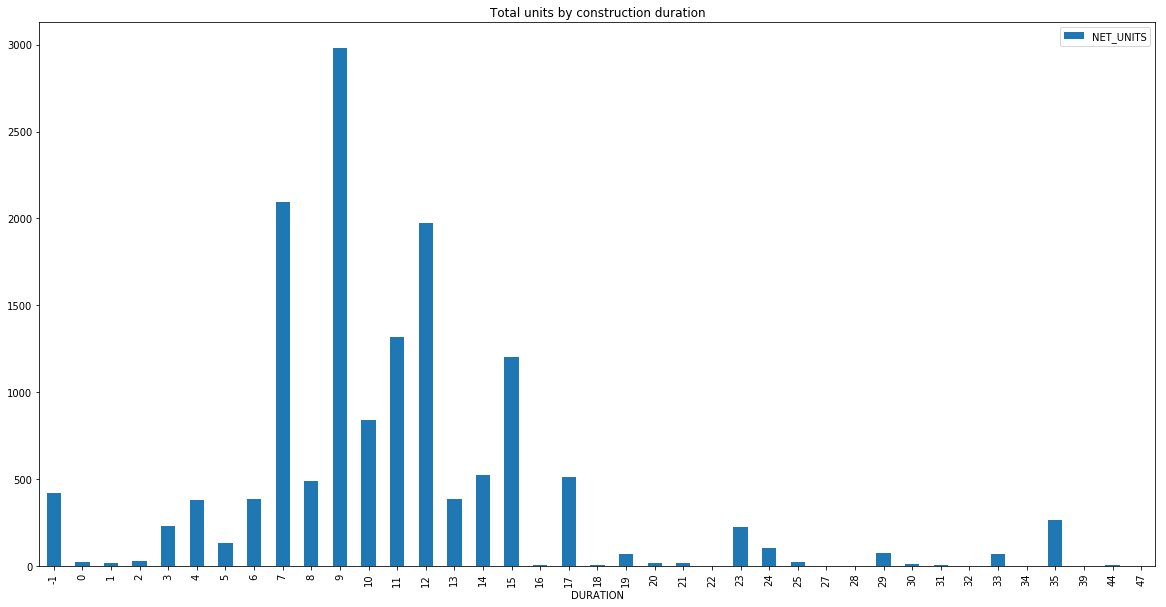

In [266]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Total units by construction duration")

In [267]:
def mean_std_norm(column):
    return (column - column.mean()) / column.std()

def min_max_norm(column):
    return (column - column.min())/(column.max() - column.min())

result = incomplete.copy()

complete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(complete['PERMIT_DATE_YEAR'])
incomplete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(incomplete['PERMIT_DATE_YEAR'])

complete['UNITS_NORM'] = mean_std_norm(complete['UNITS'])
incomplete['UNITS_NORM'] = mean_std_norm(incomplete['UNITS'])

complete['NET_UNITS_NORM'] = mean_std_norm(complete['NET_UNITS'])
incomplete['NET_UNITS_NORM'] = mean_std_norm(incomplete['NET_UNITS'])

complete['COST_NORM'] = mean_std_norm(complete['COST'])
incomplete['COST_NORM'] = mean_std_norm(incomplete['COST'])


columns_to_show = ['NAMEADDR', 'UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'DURATION_PREDICTED', 
                   'YEAR_END', 'QUARTER_END' , 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'COST']

In [268]:
display(permits.head())
permits = permits[(permits["PERMIT_TYPE"] == "new construction wood frame") | 
                  (permits["PERMIT_TYPE"] == "new construction") |
                  (permits["PERMIT_TYPE"] == "additions alterations or repairs")].reset_index()
permits = permits[(permits['PERMIT_STATUS'] == 'issued') & (permits['NET_UNITS_'] > 0) & (permits['NET_UNITS_'] < 800)]

permits['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(permits['PERMIT_DATE']).year
permits['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(permits['PERMIT_DATE']).quarter

permits['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(permits['PERMIT_DATE_YEAR'])

permits['UNITS_NORM'] = mean_std_norm(permits['UNITS_'])

permits['NET_UNITS_NORM'] = mean_std_norm(permits['NET_UNITS_'])

permits['COST'] = permits['COST'].fillna(permits['COST'].mean()).astype('int64')
permits['COST_NORM'] = mean_std_norm(permits['COST'])

permits[['UNITS', 'NET_UNITS']] = permits[['UNITS_', 'NET_UNITS_']].astype('int64')


#permits.sort_values(['NET_UNITS_'], ascending=False)

,PERMIT_DATE,PERMIT_STATUS_DATE,PERMIT_STATUS,COST,PERMIT_TYPE,UNITS_BEFORE_,UNITS_,NAMEADDR_,NET_UNITS_
PERMIT_ID,,,,,,,,,
N20000109571,2006-08-29,12/08/2008,complete,506000.0,new construction wood frame,0.0,2.0,Benton Ave 360,2.0
N20000112863,2006-08-29,12/08/2008,complete,506000.0,new construction wood frame,0.0,2.0,Benton Ave 340,2.0
N20000112900,2004-08-31,08/31/2004,issued,NaN,demolitions,2.0,0.0,Kirkham St 507,-2.0
N20000112900,2004-08-31,08/31/2004,issued,NaN,demolitions,2.0,0.0,Kirkham St 505,-2.0
N20000112908,2004-08-31,11/15/2005,complete,438000.0,new construction wood frame,0.0,2.0,Kirkham St 505,2.0


In [269]:
X_train, X_val, y_train, y_val = train_test_split(
    complete, 
    complete['DURATION'], 
    test_size=0.3) 

train_columns = ['NET_UNITS_NORM', 'PERMIT_DATE_YEAR_NORM', 'PERMIT_DATE_QUARTER', 'COST_NORM', 'UNITS_NORM']

def plot_diffs(pred, act):
    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    width = 0.4

    pred.plot(y = 'NET_UNITS', kind='bar', color='red', ax=ax, width=width, position=1)
    act.plot(y = 'NET_UNITS', kind='bar', color='blue', ax=ax2, width=width, position=0)
    ax.set_ylabel('Total Net Units')
        
def train(model):
    return model.fit(X_train[train_columns], y_train)

def validate(model):
    print("Validation on historical data:")
    y_val_predicted = model.predict(X_val[train_columns])
    X_val['DURATION_PREDICTED'] = np.ceil(y_val_predicted)
    X_val['YEAR_END_PREDICTED'] = np.floor(X_val['PERMIT_DATE_YEAR'] + (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) / 4)
    X_val['QUARTER_END_PREDICTED'] = (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) % 4 + 1
    
    pred_sum = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum()
    act_sum = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].sum()
    plot_diffs(pred_sum, act_sum)    
    
    #pred_mean = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].mean()
    #act_mean = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].mean()
    #plot_diffs(pred_mean, act_mean)
    
    # prediction error
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_val_predicted))
    
    display(X_val[columns_to_show].sort_values(by=['NET_UNITS'],ascending=False).head(15))
    
def predict_with_model(model):
    print("Prediction for not completed buildings:")
    duration_predicted = model.predict(incomplete[train_columns])
    result['DURATION_PREDICTED'] = np.ceil(duration_predicted).astype('int64')
    result['QUARTERS_LEFT'] = (result['DURATION_PREDICTED'] - result['DURATION']).astype('int64')
    result['YEAR_END_PREDICTED'] = np.floor(result['PERMIT_DATE_YEAR'] + 
                                            (result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) / 4
                                           ).astype('int64')
    result['QUARTER_END_PREDICTED'] = ((result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) % 4 + 1).astype('int64')

    prediction = result[columns_to_show + ['QUARTERS_LEFT']].sort_values(by=['NET_UNITS'],ascending=False).reset_index().drop_duplicates(subset=['PERMIT_ID'], keep="first")
    prediction.to_csv("data_complete/predictions.csv")
    
    grouped = prediction.sort_values(['NET_UNITS']).groupby(['QUARTERS_LEFT']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Net units deliv  ered by quarters left")
    
    display(prediction.head(30))

In [270]:
# with random forest

#model = train(RandomForestRegressor(n_estimators=8, max_depth=6, criterion="mse", min_samples_split=6))
#print('Feature importances: \n', model.feature_importances_)
#validate(model)

Validation on historical data:
Mean squared error: 18.68


,NAMEADDR,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST
PERMIT_ID,,,,,,,,,,,,
N201207124717,201 FOLSOM ST,656,656,2013,2,12,9.0,2016,1,2015.0,4.0,110545000
N201112070227,POTRERO1010 (BLDG 1 OF 2),470,470,2012,3,17,12.0,2016,3,2015.0,4.0,25000000
N201307303137,350 08TH ST,416,416,2014,1,12,11.0,2016,4,2017.0,1.0,123000000
N201304023626,280 BEALE ST,409,409,2013,3,9,9.0,2015,3,2016.0,1.0,131088316
N201112070234,1006 / 1050 16TH ST & 1380 07TH ST,393,393,2012,3,15,9.0,2016,1,2015.0,1.0,98068000
N201108233049,55 9th St,273,273,2012,2,10,9.0,2014,3,2014.0,4.0,84965000
N201312184508,1634 - 1690 PINE ST,260,260,2014,4,7,7.0,2016,2,2016.0,4.0,105000000
N201404042522,MISSION BAY BLOCK 7,200,200,2014,4,9,9.0,2016,4,2017.0,2.0,33857234
N201212216752,1400 MISSION ST,190,190,2013,2,10,11.0,2015,3,2016.0,2.0,65000000


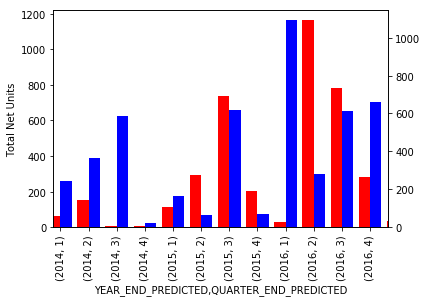

In [271]:
model = train(MLPClassifier(hidden_layer_sizes=(20), random_state=1))
#print('Coefficients: \n', model.coef_)
validate(model)

Prediction for not completed buildings:


,PERMIT_ID,NAMEADDR,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST,QUARTERS_LEFT
0,N201603172392,HOPE SF POTRERO (BP ISSUED),1600,994,2016,4,2,9,2017,1,2019,2,21800000,7
1,N201309045886,801 BRANNAN ST,557,557,2014,3,11,9,2017,1,2017,1,127060484,-2
2,N201209069080,TRINITY PLAZA,550,550,2013,4,14,9,2017,1,2016,2,133333000,-5
3,N201406138394,150 VAN NESS AV,431,431,2016,2,4,11,2017,1,2019,2,108000000,7
8,N201404304554,41 TEHAMA ST,418,418,2015,3,7,9,2017,1,2018,1,106869000,2
9,N201406259383,800 INDIANA ST,326,326,2015,4,6,9,2017,1,2018,2,115000000,3
10,N201312234917,1201 - 1225 TENNESSEE ST,300,300,2015,2,8,11,2017,1,2018,2,73394456,3
11,N201408133775,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,198,198,2015,3,7,7,2017,1,2017,3,86000000,0
12,N201408133766,MISSION BAY BLOCK 1 (RESIDENTIAL) CHANNEL,152,152,2015,3,7,7,2017,1,2017,3,50000000,0
13,N201507272485,MISSION BAY BLOCK 6E,143,143,2016,1,5,11,2017,1,2019,1,48657306,6


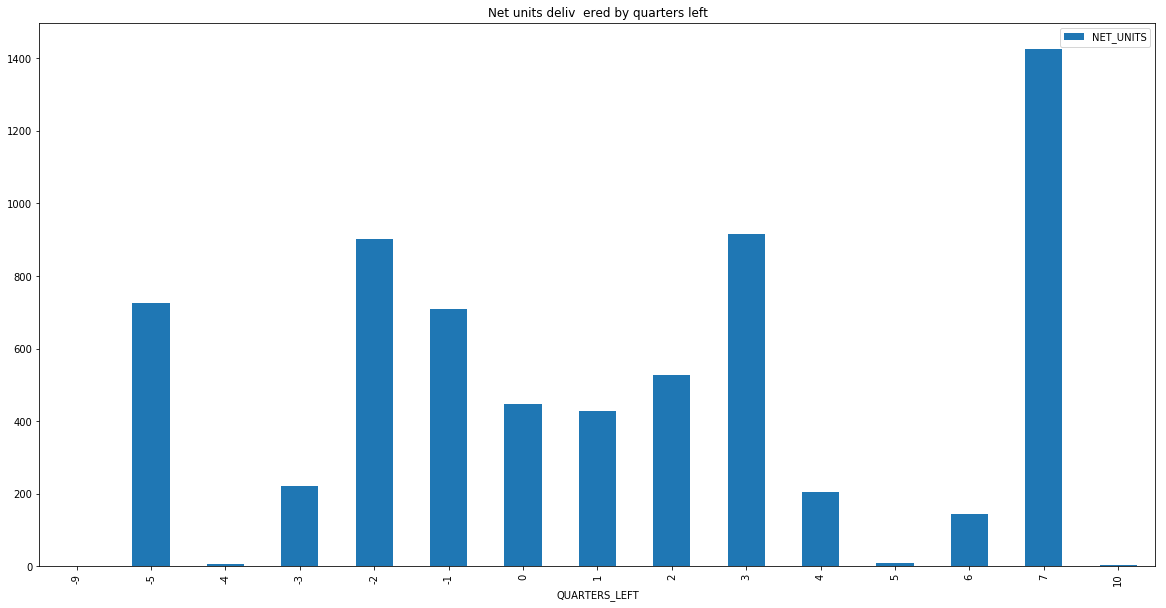

In [272]:
predict_with_model(model)

In [273]:
columns_to_show = ['PERMIT_ID', 'NAMEADDR_', 'UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION_PREDICTED', 
                   'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'COST']

duration_predicted = model.predict(permits[train_columns])
permits['DURATION_PREDICTED'] = np.ceil(duration_predicted).astype('int64')
permits['YEAR_END_PREDICTED'] = np.floor(permits['PERMIT_DATE_YEAR'] + 
                                         (permits['PERMIT_DATE_QUARTER'] + permits['DURATION_PREDICTED']) / 4
                                        ).astype('int64')
permits['QUARTER_END_PREDICTED'] = ((permits['PERMIT_DATE_QUARTER'] + permits['DURATION_PREDICTED']) % 4 + 1).astype('int64')
permits = permits[columns_to_show]
permits.to_csv("data_complete/issued_predictions.csv")
permits = permits.sort_values(['NET_UNITS'], ascending=False).drop_duplicates(subset=['PERMIT_ID'], keep="first")
display(permits.head(30))
permits.to_csv("data_complete/issued_predictions.csv")

,PERMIT_ID,NAMEADDR_,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION_PREDICTED,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST
36897,N201606200387,Mission St 1500,550,550,2017,4,9,2020,2,400000000
30383,N201310280433,08th St 33,550,550,2013,4,12,2017,1,3000000
38010,N201707131860,01st St 245,546,546,2017,4,9,2020,2,1
33090,N201412234418,01st St 245,546,546,2015,4,9,2018,2,207680000
33545,N201503110506,Folsom St 500,545,545,2016,1,11,2019,1,189838000
38020,N201707202450,Market St 1169,501,501,2017,3,9,2020,1,12760000
35582,N201511203265,Market St 1169,501,501,2016,4,9,2019,2,177300000
30538,N201311152095,Mission St 1188,440,440,2013,4,9,2016,2,400000
37703,N201701247758,Brannan St 801,434,434,2017,1,12,2020,2,250000
35761,N201512175338,Brannan St 801,434,434,2016,3,9,2019,1,5700000


In [258]:
permits.head()

,PERMIT_ID,NAMEADDR_,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION_PREDICTED,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST
36897,N201606200387,Mission St 1500,550,550,2017,4,7,2019,4,400000000
30383,N201310280433,08th St 33,550,550,2013,4,12,2017,1,3000000
38010,N201707131860,01st St 245,546,546,2017,4,9,2020,2,1
33090,N201412234418,01st St 245,546,546,2015,4,9,2018,2,207680000
33545,N201503110506,Folsom St 500,545,545,2016,1,12,2019,2,189838000


Coefficients: 
 [ 0.94724971 -7.41414378 -0.99673516 -0.35496398 -0.48668202]
Validation on historical data:
Mean squared error: 10.86


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST,NAMEADDR
PERMIT_ID,,,,,,,,,,,,
N201304023626,409,409,2013,3,9,10.0,2015,3,2016.0,2.0,131088316.0,280 BEALE ST
N201009140800,320,320,2012,3,12,14.0,2015,2,2016.0,2.0,75000000.0,45 LANSING ST
N201108233049,273,273,2012,2,10,14.0,2014,3,2016.0,1.0,84965000.0,55 9th St
N201409116118,202,202,2015,4,4,3.0,2016,3,2016.0,4.0,14000000.0,1095 MARKET ST
N201012036075,150,150,2011,1,14,19.0,2014,2,2016.0,1.0,52324967.0,1000 Fourth Street (block 13 East)
N9924080S,132,132,2006,1,35,37.0,2014,3,2015.0,3.0,11600000.0,833-881 Jamestown
N201209059005,116,116,2013,3,11,10.0,2016,1,2016.0,2.0,21500000.0,55 LAGUNA ST (BLDG 1)
N201111179162,106,106,2012,3,8,13.0,2014,2,2016.0,1.0,24000000.0,740 Illinois St And 2121 Third St
N201012156753,90,90,2011,3,12,17.0,2014,2,2016.0,1.0,30277000.0,101 Golden Gate Av


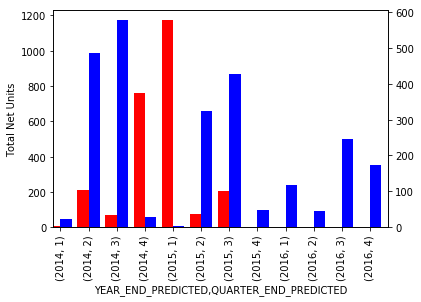

In [37]:
# with linear regression

#model = train(linear_model.LinearRegression(fit_intercept=True, normalize=False))
#print('Coefficients: \n', model.coef_)
#validate(model)

Prediction for not completed buildings:


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,COST,NAMEADDR,QUARTERS_LEFT
PERMIT_ID,,,,,,,,,,,,,
N201603172392,1600,994,2016,4,2,5.0,2017,1,2018.0,2.0,2.180000e+07,HOPE SF POTRERO (BP ISSUED),3.0
N201309045886,557,557,2014,3,11,14.0,2017,1,2018.0,2.0,1.270605e+08,801 BRANNAN ST,3.0
N201209069080,550,550,2013,4,14,18.0,2017,1,2018.0,3.0,1.333330e+08,TRINITY PLAZA,4.0
N201406138394,431,431,2016,2,4,6.0,2017,1,2018.0,1.0,1.080000e+08,150 VAN NESS AV,2.0
N201404304554,418,418,2015,3,7,10.0,2017,1,2018.0,2.0,1.068690e+08,41 TEHAMA ST,3.0
N201406259383,326,326,2015,4,6,9.0,2017,1,2018.0,2.0,1.150000e+08,800 INDIANA ST,3.0
N201312234917,300,300,2015,2,8,11.0,2017,1,2018.0,2.0,7.339446e+07,1201 - 1225 TENNESSEE ST,3.0
N201408133775,198,198,2015,3,7,10.0,2017,1,2018.0,2.0,8.600000e+07,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,3.0
N201408133766,152,152,2015,3,7,10.0,2017,1,2018.0,2.0,5.000000e+07,MISSION BAY BLOCK 1 (RESIDENTIAL) CHANNEL,3.0


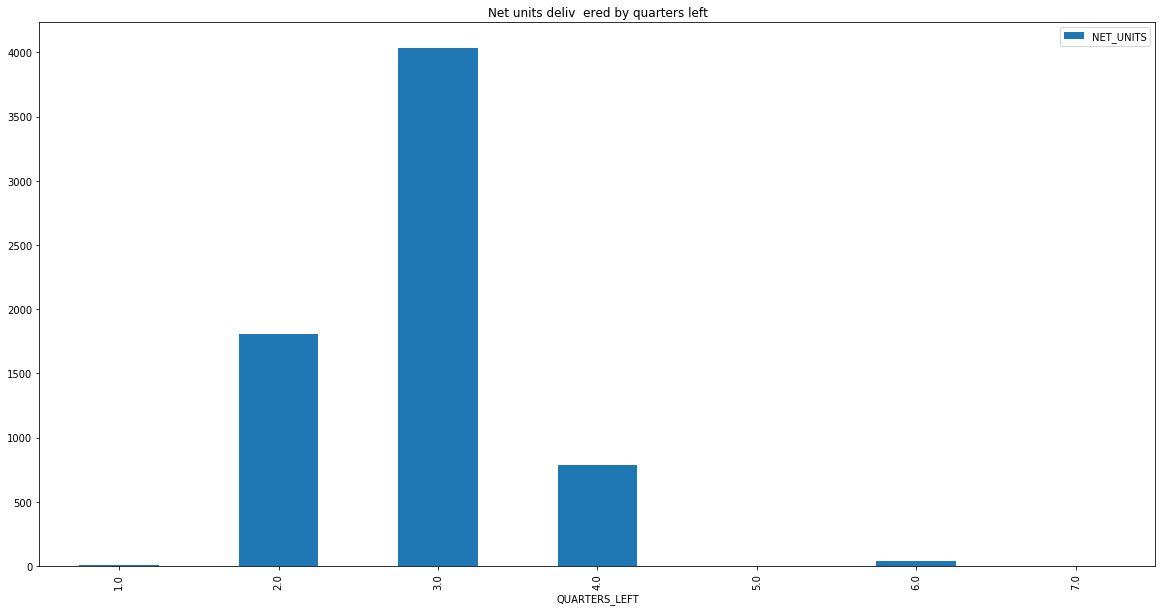

In [663]:
predict_with_model(model)